In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank


from typing import Literal
from pydantic import BaseModel, Field


import config
from dotenv import load_dotenv
import os

# Setup

In [ ]:
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")



embeddings = OllamaEmbeddings(
    model="nomic-embed-text:v1.5"
)

sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=QDRANT_URL,
    prefer_grpc=True,
    api_key=QDRANT_API_KEY,
    collection_name="mlops_document",
    retrieval_mode=RetrievalMode.HYBRID,
)

hybrid_rerank_qdrant_retriever = qdrant.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 20},
)

groq_llama3_1_70b = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    api_key=GROQ_API_KEY
)

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

# 1. Define Graph State

In [6]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langchain_core.documents import Document


class GraphState(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    rag_answer: str
    supervisor_route_choice: str
    hybrid_rerank_qdrant_retriever: QdrantVectorStore
    groq_llama3_1_70b: ChatGroq

# 2. Define Nodes

In [7]:
# Supervisor Node

def supervisor_agent(state):
    question = state['question']
    groq_llama3_1_70b = state['groq_llama3_1_70b']

    # Data model
    class SupervisorRoute(BaseModel):
        """Route a user query to the most relevant datasource."""

        route: Literal["vector_store_agent", "apology_agent"] = Field(
            description="Given a user question choose to route it to vector_store_agent or apology_agent. ",
        )


    structured_supervisor_llm = groq_llama3_1_70b.with_structured_output(SupervisorRoute)

    # Prompt
    system = """You are an expert at routing a user question to a vector_store or web search.
    The vectorstore contains documents related to machine learning operation, machine learning and data science.
    Use the vector_store_agent for questions on these topics. Otherwise, use apology_agent."""
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    supervisor_agent = route_prompt | structured_supervisor_llm

    supervisor_choice = supervisor_agent.invoke(question)

    return {"supervisor_route_choice": supervisor_choice.route}

# Mlops Agent
def mlops_agent(state):
    query = state['question']
    hybrid_rerank_qdrant_retriever = state['hybrid_rerank_qdrant_retriever']
    groq_llama3_1_70b = state['groq_llama3_1_70b']

    # -----------------------------------------------------------------
    # 1. Retrieval
    # -----------------------------------------------------------------

    compressor = FlashrankRerank(
        model="ms-marco-MiniLM-L-12-v2",
        top_n=4
    )
    
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=hybrid_rerank_qdrant_retriever
    )

    retrieved_docs = compression_retriever.invoke(query)

    # Format the docs
    doc_context = "\n\n".join(doc.page_content for doc in retrieved_docs)

    # -----------------------------------------------------------------
    # 2. Generation
    # -----------------------------------------------------------------
    # Prompt
    template = """
    You are an assistant for question-answering tasks. 
    Please answer the question based on the context provided.
    Do not tell the user that you are referring to the context to answer the question 
    If you don't know the answer or the context does not answer the question, just say that you don't know. 
    Elaborate your answer in well structured format.

    Question: {question} 
    Context: {context} 
    Answer:
    """

    prompt = ChatPromptTemplate.from_template(template)


    llm = groq_llama3_1_70b

    rag_chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    rag_answer =  rag_chain.invoke({"question": query, "context":doc_context})

    return {'rag_answer': rag_answer}

# Apology Agent
def apology_agent(state):
    question = state['question']
    groq_llama3_1_70b = state['groq_llama3_1_70b']

    # Prompt
    template = """
    You are an assistant for question-answering tasks related to machine learning operation, machine learning and data science only. 
    The question are not related to machine learning operation, machine learning and data science.
    Do not answer the question and apologize to the user.

    Question: {question} 
    Apology:
    """

    prompt = ChatPromptTemplate.from_template(template)

    llm = groq_llama3_1_70b

    apology_chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    apology_text =  apology_chain.invoke({"question": question})

    return {
        "rag_answer": apology_text
    }

# 3. Define Conditional Edges

In [8]:
def supervisor_route(state):
    supervisor_route_choice = state['supervisor_route_choice']

    if supervisor_route_choice == "vector_store_agent":
        return "mlops_agent"
    elif supervisor_route_choice == "apology_agent":
        return "apology_agent"

# 4. Define the Graph

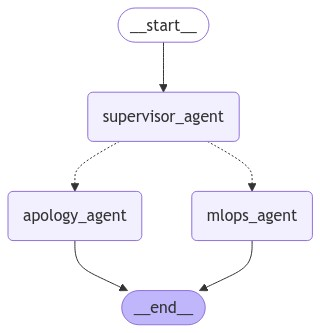

In [10]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

# Initialise the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("mlops_agent", mlops_agent)
workflow.add_node("apology_agent", apology_agent)


# Add Edges
workflow.set_entry_point("supervisor_agent")
workflow.add_conditional_edges(
    source="supervisor_agent",
    path=supervisor_route,
    path_map={
        "mlops_agent": "mlops_agent",
        "apology_agent": "apology_agent",
    }
)
workflow.add_edge("mlops_agent", END)
workflow.add_edge("apology_agent", END)

rag_graph = workflow.compile()

display(Image(rag_graph.get_graph().draw_mermaid_png()))

# 5. Test the Graph

In [12]:
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

embeddings = OllamaEmbeddings(
    model="nomic-embed-text:v1.5"
)

sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=QDRANT_URL,
    prefer_grpc=True,
    api_key=QDRANT_API_KEY,
    collection_name="mlops_document",
    retrieval_mode=RetrievalMode.HYBRID,
)

hybrid_rerank_qdrant_retriever = qdrant.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 20},
)

groq_llama3_1_70b = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    api_key=GROQ_API_KEY
)

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

In [13]:
question = "What is data leakage ?"
graph_state = {
    "question":question,
    "rag_answer":"None",
    "supervisor_route_choice":"None",
    "hybrid_rerank_qdrant_retriever":hybrid_rerank_qdrant_retriever,
    "groq_llama3_1_70b": groq_llama3_1_70b
}
result = rag_graph.invoke(graph_state)
print(result['rag_answer'])

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


**What is Data Leakage?**

Data leakage refers to the phenomenon where a form of the label or target variable "leaks" into the set of features used for making predictions, and this same information is not available during inference. This can cause machine learning models to fail in unexpected and spectacular ways, even after extensive evaluation and testing.

**Examples of Data Leakage**

1. **Predicting COVID-19 risks from medical scans**: A model was trained on a mix of scans taken when patients were lying down and standing up. The model learned to predict serious COVID-19 risk from a person's position, which is not a relevant feature for making predictions.
2. **Predicting COVID-19 risks from text font**: A model was trained on scans labeled with different fonts from various hospitals. The model learned to predict COVID-19 risk from the font used, which is not a relevant feature for making predictions.
3. **Predicting lung cancer from CT scans**: A model was trained on CT scans from

In [14]:
question = "Who is cristiano ronaldo?"
graph_state = {
    "question":question,
    "rag_answer":"None",
    "supervisor_route_choice":"None",
    "hybrid_rerank_qdrant_retriever":hybrid_rerank_qdrant_retriever,
    "groq_llama3_1_70b": groq_llama3_1_70b
}
result = rag_graph.invoke(graph_state)
print(result['rag_answer'])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I apologize, but I'm a specialized assistant for question-answering tasks related to machine learning operation, machine learning, and data science only. I'm not equipped to provide information on general knowledge topics, including sports or celebrities. If you have any questions related to machine learning or data science, I'd be happy to help.
